In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=1, max_galaxies=1, num_bands=5)

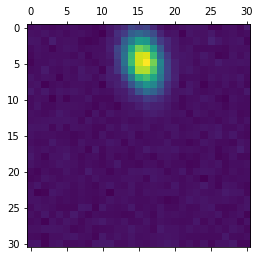

In [4]:
data1 = galaxy_data.__getitem__(1)

plt.matshow(data1['image'][0, :, :])

In [5]:
# The VAE
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [6]:
state_dict = torch.load("./galaxy_vae.dat", map_location='cpu')
galaxy_vae.load_state_dict(state_dict, strict=False)

galaxy_vae.eval(); 

In [7]:
image = torch.Tensor([data1['image']])
var =  torch.Tensor([data1['image']])

In [8]:
pixel_probs = galaxy_vae.attn_enc(image, var)

In [9]:
log_q_a, pixel_2d, keep_on = galaxy_vae.pixel_sample(pixel_probs)

In [10]:
z_mean, z_var = galaxy_vae.enc(image, pixel_2d)

In [11]:
recon_mean, recon_var = galaxy_vae.dec(pixel_2d, keep_on, z_mean)

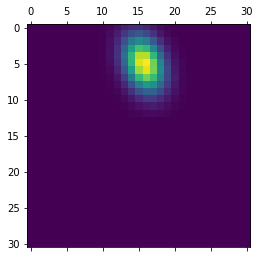

In [12]:
plt.matshow(recon_mean[0, 0, :, :].detach())

In [51]:
class CelesteRNN(nn.Module):

    def __init__(self, sout, one_galaxy_vae, max_detections=1):
        super(CelesteRNN, self).__init__()
        
        self.one_galaxy_vae = one_galaxy_vae
        self.max_detections = max_detections
        
        # number of discrete random variables
        self.n_discrete_latent = (sout - self.one_galaxy_vae.attn_enc.attn_offset)**2
        
    def get_pixel_probs(self, image, image_var): 
        pixel_probs = self.one_galaxy_vae.attn_enc(image, image_var)      
        
        # just for myself to make sure I understand this right
        assert (pixel_probs.size(1) - 1) == self.n_discrete_latent
        
        return pixel_probs
    
    def sample_pixel(self, pixel_probs): 
        pixel_dist = Categorical(pixel_probs)
        return pixel_dist.sample()
        
    def get_loss_conditional_a(self, image, pixel_1d): 
        
        is_on = (pixel_1d < (self.n_discrete_latent - 1)).float()

        # pass through galaxy encoder
        pixel_2d = self.one_galaxy_vae.pixel_1d_to_2d(pixel_1d)
        z_mean, z_var = self.one_galaxy_vae.enc(image, pixel_2d)
                
        # sample z
        q_z = Normal(z_mean, z_var.sqrt())
        z_sample = q_z.rsample()
        
        # kl term for continuous latent vars
        log_q_z = q_z.log_prob(z_sample).sum(1)
        p_z = Normal(torch.zeros_like(z_sample), torch.ones_like(z_sample))
        log_p_z = p_z.log_prob(z_sample).sum(1)
        kl_z = is_on * (log_q_z - log_p_z)
                
        # run through decoder        
        recon_mean, recon_var = self.one_galaxy_vae.dec(pixel_2d, is_on, z_sample)

        # get recon loss
        recon_losses = -Normal(recon_mean, (recon_var + 1e-8).sqrt()).log_prob(image)
        recon_losses = recon_losses.view(image.size(0), -1).sum(1)
        
        print(recon_losses)
        
        conditional_loss = recon_losses + kl_z
        
        return conditional_loss, recon_mean, recon_var
    
    def get_reinforce_grad_sample(self, f_z_i, log_q_i, use_baseline = False):
        if use_baseline:
            z_sample2 = self.sample_pixel(class_weights)
            baseline = self.experiment_class.f_z(z_sample2).detach()
        else:
            baseline = 0.0

        return (f_z_i.detach() - baseline) * log_q_i

    def get_partial_marginalization_loss(self, image, topk, alpha = 0.0): 
        
        # get class weights from the variational distribution
        log_q = self.get_pixel_probs()
        class_weights = torch.exp(log_q.detach())
        
        # this is the indicator C_\alpha
        concentrated_mask, concentrated_indx = pm_lib.get_concentrated_mask(class_weights, alpha, topk)
        concentrated_mask = concentrated_mask.float().detach()

        # the summed term
        summed_term = 0.0
        full_loss = 0.0
        
        seq_tensor = torch.LongTensor([i for i in range(class_weights.shape[0])])

        for a in range(topk):
            cond_loss_a = self.get_loss_conditional_z(image, concentrated_indx[:, a])
            log_q_a = log_q[seq_tensor, a]

            reinforce_grad_sample = self.get_reinforce_grad_sample(cond_loss_a, log_q_i, use_baseline)
            summed_term = summed_term + \
                ((reinforce_grad_sample + cond_loss_a) * self.class_weights[seq_tensor, i]).sum()

        # sampled term
        sampled_weight = torch.sum(self.class_weights * (1 - concentrated_mask), dim = 1, keepdim = True)

        if not(topk == self.class_weights.shape[1]):
            conditional_class_weights = \
                self.class_weights * (1 - concentrated_mask) / (sampled_weight)

            conditional_a_sample = self.sample_pixel(conditional_class_weights)

            # just for my own sanity ...
            assert np.all((1 - concentrated_mask)[self.seq_tensor, conditional_a_sample].numpy() == 1.)

            f_z_i_sample = self.get_loss_conditional_z(conditional_a_sample)
            log_q_i_sample = log_q[seq_tensor, conditional_z_sample]

            sampled_term = self.get_reinforce_grad_sample(f_z_i_sample, log_q_i_sample, use_baseline) + \
                                    f_z_i_sample

        else:
            sampled_term = 0.

        return (sampled_term * sampled_weight.squeeze()).sum() + summed_term, full_loss

    
#     def forward(self, image, background, save_history=False):
#         log_q_as = 0.0
#         is_on = torch.ones_like(image[:, 0, 0, 0])
#         recon_means = background.data.clone()
#         recon_vars = background.data.clone()
#         latent_losses = 0.0
#         history = []

#         for t in range(self.max_detections):
#             res_image = image - recon_means

#             pixel_2d, is_on, z, log_q_a, latent_loss = self.sample_latent(res_image, recon_vars)
#             recon_mean, recon_var = self.dec(pixel_2d, is_on, z)

#             if save_history and is_on:
#                 history.append(recon_mean)

#             # save iteration state
#             recon_means += recon_mean
#             recon_vars += recon_var
#             latent_losses += latent_loss
#             log_q_as += log_q_a

#         # -log p(x | a, z)
#         recon_losses = -Normal(recon_means, recon_vars.sqrt()).log_prob(image)
#         recon_losses = recon_losses.view(image.size(0), -1).sum(1)

#         if save_history:
#             return recon_means, history

#         return recon_means, recon_vars, log_q_as, latent_losses, recon_losses


In [52]:
galaxy_rnn = CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [53]:
pixel_probs = galaxy_vae.attn_enc(image, var)

In [54]:
pixel_1d = galaxy_rnn.sample_pixel(pixel_probs)

In [55]:
pixel_1d

tensor([ 35])

In [56]:
_ = galaxy_rnn.get_loss_conditional_z(image, pixel_1d)

tensor([ 9.4088e+16])
